In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.evaluation import ( 
    evaluate_pytorch_model, 
    evaluate_onnx_model,
    measure_pytorch_speed,
    measure_onnx_speed,
    print_metrics,
    compare_models
)


In [4]:
DATA_DIR = Path('../data/lpr_yolo')
TRAIN_IMAGES = DATA_DIR / 'train' / 'images'
TRAIN_LABELS = DATA_DIR / 'train' / 'labels'
VAL_IMAGES = DATA_DIR / 'val' / 'images'
VAL_LABELS = DATA_DIR / 'val' / 'labels'
TEST_IMAGES = DATA_DIR / 'test' / 'images'
TEST_LABELS = DATA_DIR / 'test' / 'labels'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Кастомная модель на базе MobileNetV3 для детекции угловых точек

Dataset с Letterbox Resize,сохраняет пропорции изображения, добавляя padding.

In [6]:
class KeypointDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=224):
        self.images = sorted(Path(images_dir).glob('*.png'))
        self.labels_dir = Path(labels_dir)
        self.img_size = img_size
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = str(self.images[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h0, w0 = img.shape[:2]  

        label_file = self.labels_dir / (Path(img_path).stem + '.txt')
        with open(label_file, 'r') as f:
            line = f.readline().strip().split()
        kpts = np.array([float(x) for x in line[5:]]).reshape(-1, 3)[:, :2]

        kpts[:, 0] *= w0
        kpts[:, 1] *= h0
        
        new_size = self.img_size
        scale = min(new_size / w0, new_size / h0)
        nw, nh = int(w0 * scale), int(h0 * scale)
        pad_x = (new_size - nw) / 2
        pad_y = (new_size - nh) / 2
        
        resized = cv2.resize(img, (nw, nh))

        padded = np.full((new_size, new_size), 114, dtype=np.uint8)  
        padded[int(pad_y):int(pad_y)+nh, int(pad_x):int(pad_x)+nw] = resized

        kpts[:, 0] = kpts[:, 0] * scale + pad_x
        kpts[:, 1] = kpts[:, 1] * scale + pad_y
        
        img = torch.from_numpy(padded).float().unsqueeze(0) / 255.0
        kpts = torch.from_numpy(kpts).float().flatten()

        return img, kpts

Архитектура модели

**Encoder:** MobileNetV3-Small (pretrained на ImageNet)  
**Head:** Linear layers с Dropout для регрессии координат

In [7]:
class KeypointModel(nn.Module):
    def __init__(self, model_name='mobilenetv3_small_050', num_keypoints=4):
        super().__init__()
        self.encoder = timm.create_model(model_name, pretrained=True, in_chans=1, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_keypoints * 2)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

Подготовка данных

In [8]:
train_dataset = KeypointDataset(TRAIN_IMAGES, TRAIN_LABELS)
val_dataset = KeypointDataset(VAL_IMAGES, VAL_LABELS)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Визуализация примера

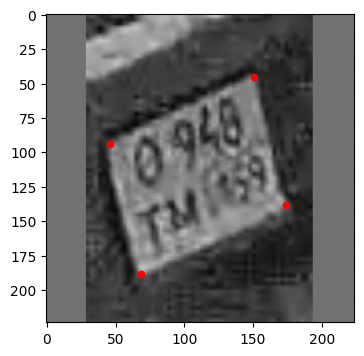

In [10]:
images, keypoints = next(iter(train_loader))

img = images[0].squeeze().numpy()  # [224, 224]
kpts = keypoints[0].view(-1, 2).numpy()  # [num_keypoints, 2]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0, vmax=1) 
plt.scatter(kpts[:, 0], kpts[:, 1], c='r', s=20)
plt.show()


### Обучение модели

In [11]:
EPOCHS = 25
LR = 1e-3

In [12]:
model = KeypointModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [13]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = '../runs/mobilenet/best_model.pth'

Path(best_model_path).parent.mkdir(parents=True, exist_ok=True)

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for imgs, kpts in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False):
        imgs, kpts = imgs.to(device), kpts.to(device)
        
        optimizer.zero_grad()
        pred = model(imgs)
        loss = criterion(pred, kpts)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, kpts in val_loader:
            imgs, kpts = imgs.to(device), kpts.to(device)
            pred = model(imgs)
            val_loss += criterion(pred, kpts).item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f} ✓ Best')
    else:
        print(f'Epoch {epoch+1}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}')

print(f'\nЛучшая модель сохранена: {best_model_path} (Val Loss: {best_val_loss:.4f})')

Epoch 1/25 | Train: 2176.0803 | Val: 274.2528 ✓ Best


Epoch 2/25 | Train: 279.8085 | Val: 83.3136 ✓ Best


Epoch 3/25 | Train: 161.6508 | Val: 75.7243 ✓ Best


Epoch 4/25 | Train: 156.2130 | Val: 73.6277 ✓ Best


Epoch 5/25 | Train: 151.5372 | Val: 73.8881


Epoch 6/25 | Train: 148.6722 | Val: 75.4020


Epoch 7/25 | Train: 143.0498 | Val: 61.2096 ✓ Best


Epoch 8/25 | Train: 128.1716 | Val: 48.1681 ✓ Best


Epoch 9/25 | Train: 118.6453 | Val: 42.6065 ✓ Best


Epoch 10/25 | Train: 116.0052 | Val: 48.3572


Epoch 11/25 | Train: 114.8357 | Val: 41.6299 ✓ Best


Epoch 12/25 | Train: 111.0905 | Val: 46.9522


Epoch 13/25 | Train: 109.3703 | Val: 32.6057 ✓ Best


Epoch 14/25 | Train: 107.7500 | Val: 33.9055


Epoch 15/25 | Train: 106.9217 | Val: 37.9177


Epoch 16/25 | Train: 104.8436 | Val: 26.5586 ✓ Best


Epoch 17/25 | Train: 100.6443 | Val: 22.8610 ✓ Best


Epoch 18/25 | Train: 101.7528 | Val: 21.1409 ✓ Best


Epoch 19/25 | Train: 98.1221 | Val: 22.6301


Epoch 20/25 | Train: 95.6829 | Val: 23.4635


Epoch 21/25 | Train: 97.2556 | Val: 20.9476 ✓ Best


Epoch 22/25 | Train: 99.4225 | Val: 23.3544


Epoch 23/25 | Train: 95.7940 | Val: 21.2055


Epoch 24/25 | Train: 97.7151 | Val: 34.3481


Epoch 25/25 | Train: 97.9227 | Val: 21.8785

Лучшая модель сохранена: runs/mobilenet/best_model.pth (Val Loss: 20.9476)


Визуализация кривых обучения

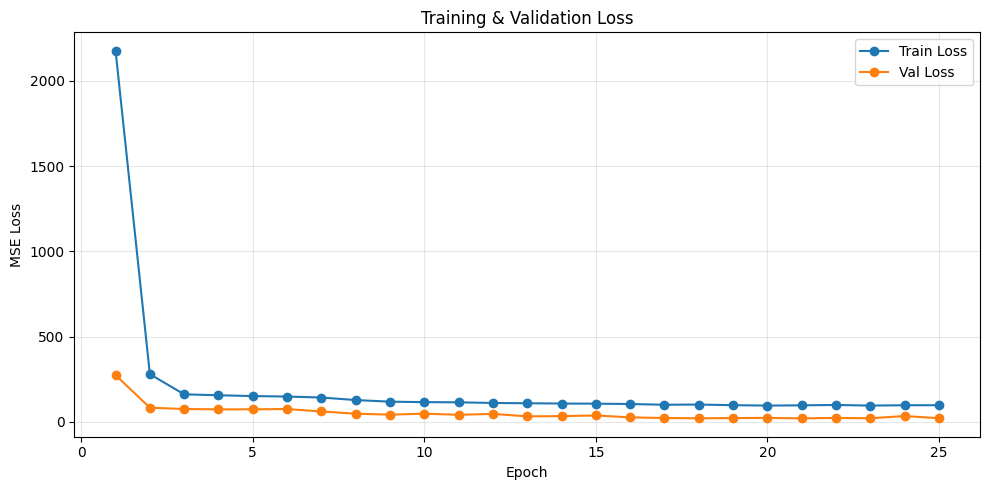

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Оценка на тестовой выборке

In [15]:
onnx_static_path = 'keypoint_model_static.onnx'
onnx_dynamic_path = 'keypoint_model_dynamic.onnx'

In [22]:
model.eval()

dummy_input = torch.randn(1, 1, 224, 224).to(device)
# Экспорт динамической ONNX  
torch.onnx.export(model, dummy_input, "keypoint_model_dynamic.onnx",
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

In [23]:
test_dataset = KeypointDataset(TEST_IMAGES, TEST_LABELS, img_size=224)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [24]:
# Оценка PyTorch модели
metrics_pt = evaluate_pytorch_model(model, test_loader, device)
speed_pt = measure_pytorch_speed(model, test_loader, device)
metrics_pt.update(speed_pt)

# ONNX
metrics_dynamic = evaluate_onnx_model(onnx_dynamic_path, test_loader)
speed_dynamic = measure_onnx_speed(onnx_dynamic_path, test_loader)
metrics_dynamic.update(speed_dynamic)

In [25]:
all_metrics = {
    "PyTorch": metrics_pt,
    "ONNX Dynamic": metrics_dynamic
}
compare_models(all_metrics)


Model                     MAE (px)     RMSE (px)    Speed (ms)     
--------------------------------------------------------------------------------
PyTorch                   5.26         6.68         14.58          
ONNX Dynamic              5.26         6.68         21.85          

